In [1]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
# https://arxiv.org/pdf/1408.5882.pdf

In [2]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.layers import Input, Layer, TextVectorization, Embedding
from tensorflow.keras.layers import SeparableConv1D, GlobalMaxPool1D, MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

In [3]:
DATASET = "imdb_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 200
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000

In [4]:
# # Load train dataset
# train = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="train", batch_size=-1))
# X_train, y_train = np.array([x.decode() for x in train["text"]]), train["label"]

# # Load test dataset
# test = tfds.as_numpy(tfds.load(DATASET, data_dir=f"data/{DATASET}", split="test", batch_size=-1))
# X_test, y_test = np.array([x.decode() for x in test["text"]]), test["label"]

# print(f"Train samples: {len(X_train)}")
# print(f"Test samples:  {len(X_test)}")

In [5]:
# print(f"Label: {y_train[0]} Text: {X_train[0]}")
# print(f"Label: {y_train[5]} Text: {X_train[5]}")
# print(f"Label: {y_test[0]} Text: {X_test[0]}")
# print(f"Label: {y_test[5]} Text: {X_test[5]}")

In [6]:
# VOCAB_SIZE = 1000
# encoder = tf.keras.layers.TextVectorization(
#     max_tokens=VOCAB_SIZE)
# encoder.adapt(X_train, batch_size = BATCH_SIZE)

In [7]:
# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]

In [8]:
# # Create a custom standardization function to strip HTML break tags '<br />'.
# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation), 
#                                   '')
  
# vectorize_layer = TextVectorization(
#     standardize = custom_standardization,
#     max_tokens =  VOCAB_SIZE,
#     output_mode = 'int',
#     output_sequence_length = MAX_SEQ_LENGTH)

# vectorize_layer.adapt(X_train, batch_size = BATCH_SIZE)

In [9]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFKYA0D/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFKYA0D/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFKYA0D/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


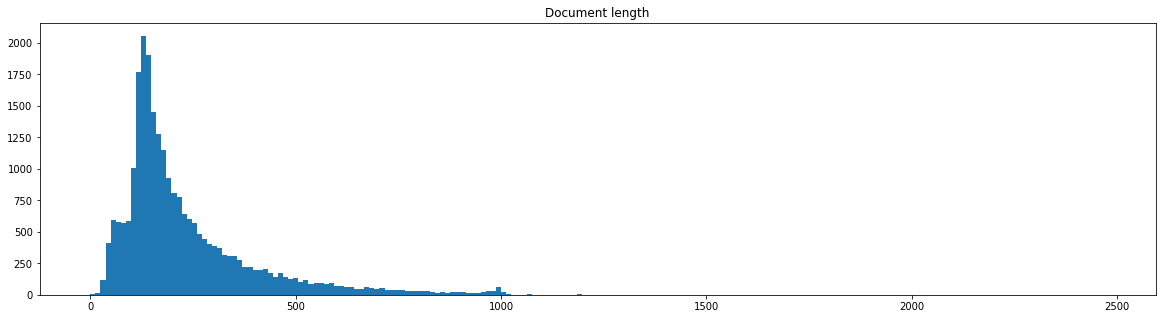

Text informations:
 - max length:   2470
 - min length:   10
 - mean length:  233.77672


In [11]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - max length:   {np.max(num_token)}")
print(f" - min length:   {np.min(num_token)}")
print(f" - mean length:  {np.mean(num_token)}")

In [12]:
VOCAB_SIZE = 44277
EMBEDDING_DIM = 32
MAX_SEQ_LENGTH = 400
KERNEL_SIZE = [3, 4, 5]
FEATURES_MAPS = [100, 100, 100]

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I have to admit, this movie moved me to the extent that I burst in tears. However, I always think about things twice, and instead of writing a eulogy that would define the film as flawless and impeccable, I prefer taking the risk of a closer look.<br /><br />First what\'s first: The movie has an undeniable impact on the viewer simply because it starts out and continues as a slow-paced movie that doesn\'t try to blow you away with the actual scenes from 9/11. Thumbs up for this stroke of genius, because, unlike Stone\'s WORLD TRADE CENTER this film fortunately doesn\'t focus on the attack itself but on the fallout which, similar to the fallout of a nuclear explosion, is hardly visible but nonetheless dangerous and devastating. The psychological impact, the sheer devastation that 9/11 caused and the havoc it wreaked on the American people is almost palpable in this movie. I think Binder managed an astute observation of the American post 9/11 society and Sandler in my opinion s

In [15]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U42')

In [17]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  10,   26,    6, ...,    0,    0,    0],
       [ 298, 3779, 4997, ...,    0,    0,    0],
       [  11,   14,    4, ...,    0,    0,    0]])

In [18]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I have to admit, this movie moved me to the extent that I burst in tears. However, I always think about things twice, and instead of writing a eulogy that would define the film as flawless and impeccable, I prefer taking the risk of a closer look.<br /><br />First what\'s first: The movie has an undeniable impact on the viewer simply because it starts out and continues as a slow-paced movie that doesn\'t try to blow you away with the actual scenes from 9/11. Thumbs up for this stroke of genius, because, unlike Stone\'s WORLD TRADE CENTER this film fortunately doesn\'t focus on the attack itself but on the fallout which, similar to the fallout of a nuclear explosion, is hardly visible but nonetheless dangerous and devastating. The psychological impact, the sheer devastation that 9/11 caused and the havoc it wreaked on the American people is almost palpable in this movie. I think Binder managed an astute observation of the American post 9/11 society and Sandler in my opinion

In [19]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

vectorize_layer.adapt(train_dataset.map(lambda text, label: text))

In [20]:
class TextCNN:
  def __init__(self, 
               vectorize_layer = None,
               kernel_sizes = [3, 4, 5],
               feature_maps = [100, 100, 100],
               dense_hidden_units = 100,
               dropout_rate = None,
               nb_classes = None):
    
    """
    Arguments:
      vocab_size : Số lượng từ tối đa trong từ điển
      embedding_dim: số chiều của vector từ
      max_seq_length: độ dài tối đa của một chuỗi từ
      kernel_sizes: mảng size của các kernel 1d trong mỗi kênh
      feature_maps: 
      dense_hidden_units:
      dropout_rate:
      nb_classes: 
    """

    self.vectorize_layer = vectorize_layer
    self.kernel_sizes = kernel_sizes
    self.feature_maps = feature_maps
    self.dense_hidden_units = dense_hidden_units
    self.dropout_rate = dropout_rate
    self.nb_classes = nb_classes  


  def create_channel(self, x, kernel_size, feature_map):

    """
    """

    x = SeparableConv1D(
        filters = feature_map,
        kernel_size = kernel_size,
        depth_multiplier = 4,
        activation = 'relu'
    )(x)
    x1 = GlobalMaxPool1D()(x)
    x2 = GlobalAveragePooling1D()(x)
    x = concatenate([x1, x2])

    # x = MaxPooling1D(pool_size=2)(x)

    # x = Dense(self.dense_hidden_units)(x)
    # if self.dropout_rate:
    #   x = Dropout(self.dropout_rate)(x)

    return Flatten()(x)

  def create_block(self, input_layer, kernel_sizes, feature_maps):

    """
    Note .......
    """

    channels = []
    for i in range(len(kernel_sizes)):
      x = self.create_channel(input_layer, kernel_sizes[i], feature_maps[i])
      channels.append(x)

    if len(channels) > 1:
      x = concatenate(channels)

    return x


  def build_model(self):

    """

    """

    if len(self.kernel_sizes) != len(self.feature_maps):
      raise Exception("Please define 'kernel_sizes' and 'feature_maps' with the same amount.")

    if not self.nb_classes:
      raise Exception("Please define 'nb_classes'")

    if not self.vectorize_layer:
      raise Exception("Please define 'vectorize_layer'.") 

    inputs = Input(shape = (1, ), dtype = tf.string)
    word2idvec = self.vectorize_layer(inputs)
    idvec2embvec = Embedding(input_dim = VOCAB_SIZE,
                             output_dim = EMBEDDING_DIM,
                             mask_zero=True)(word2idvec)

    x = self.create_block(idvec2embvec, self.kernel_sizes, self.feature_maps)
    if self.dropout_rate:
      x = layers.Dropout(self.dropout_rate)(x)
    x = Dense(self.dense_hidden_units, activation='relu', 
              kernel_regularizer='l2')(x)
    if self.dropout_rate:
      x = layers.Dropout(self.dropout_rate)(x)
    
    if self.nb_classes == 2:
      prediction = Dense(1, activation='sigmoid')(x)
    else:
      prediction = Dense(self.nb_classes, activation='softmax')(x)

    return Model(inputs = inputs,
                 outputs = prediction)


In [21]:
# from sklearn.model_selection import train_test_split

# _X_train, _X_val, _y_train, _y_val = train_test_split(
    
# )

In [22]:
model = TextCNN(vectorize_layer = vectorize_layer,
                kernel_sizes = KERNEL_SIZE,
                feature_maps = FEATURES_MAPS,
                dense_hidden_units = DENSE_HIDDEN_UNITS,
                dropout_rate = DROPOUT_RATE,
                nb_classes = NB_CLASSES).build_model()

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
# history = model.fit(x = X_train,
#                     y = y_train, 
#                     batch_size = BATCH_SIZE,
#                     epochs=10)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 400)         0           ['input_1[0][0]']                
 orization)                                                                                       
                                                                                                  
 embedding (Embedding)          (None, 400, 32)      1416864     ['text_vectorization_1[0][0]']   
                                                                                                  
 separable_conv1d (SeparableCon  (None, 398, 100)    13284       ['embedding[0][0]']          

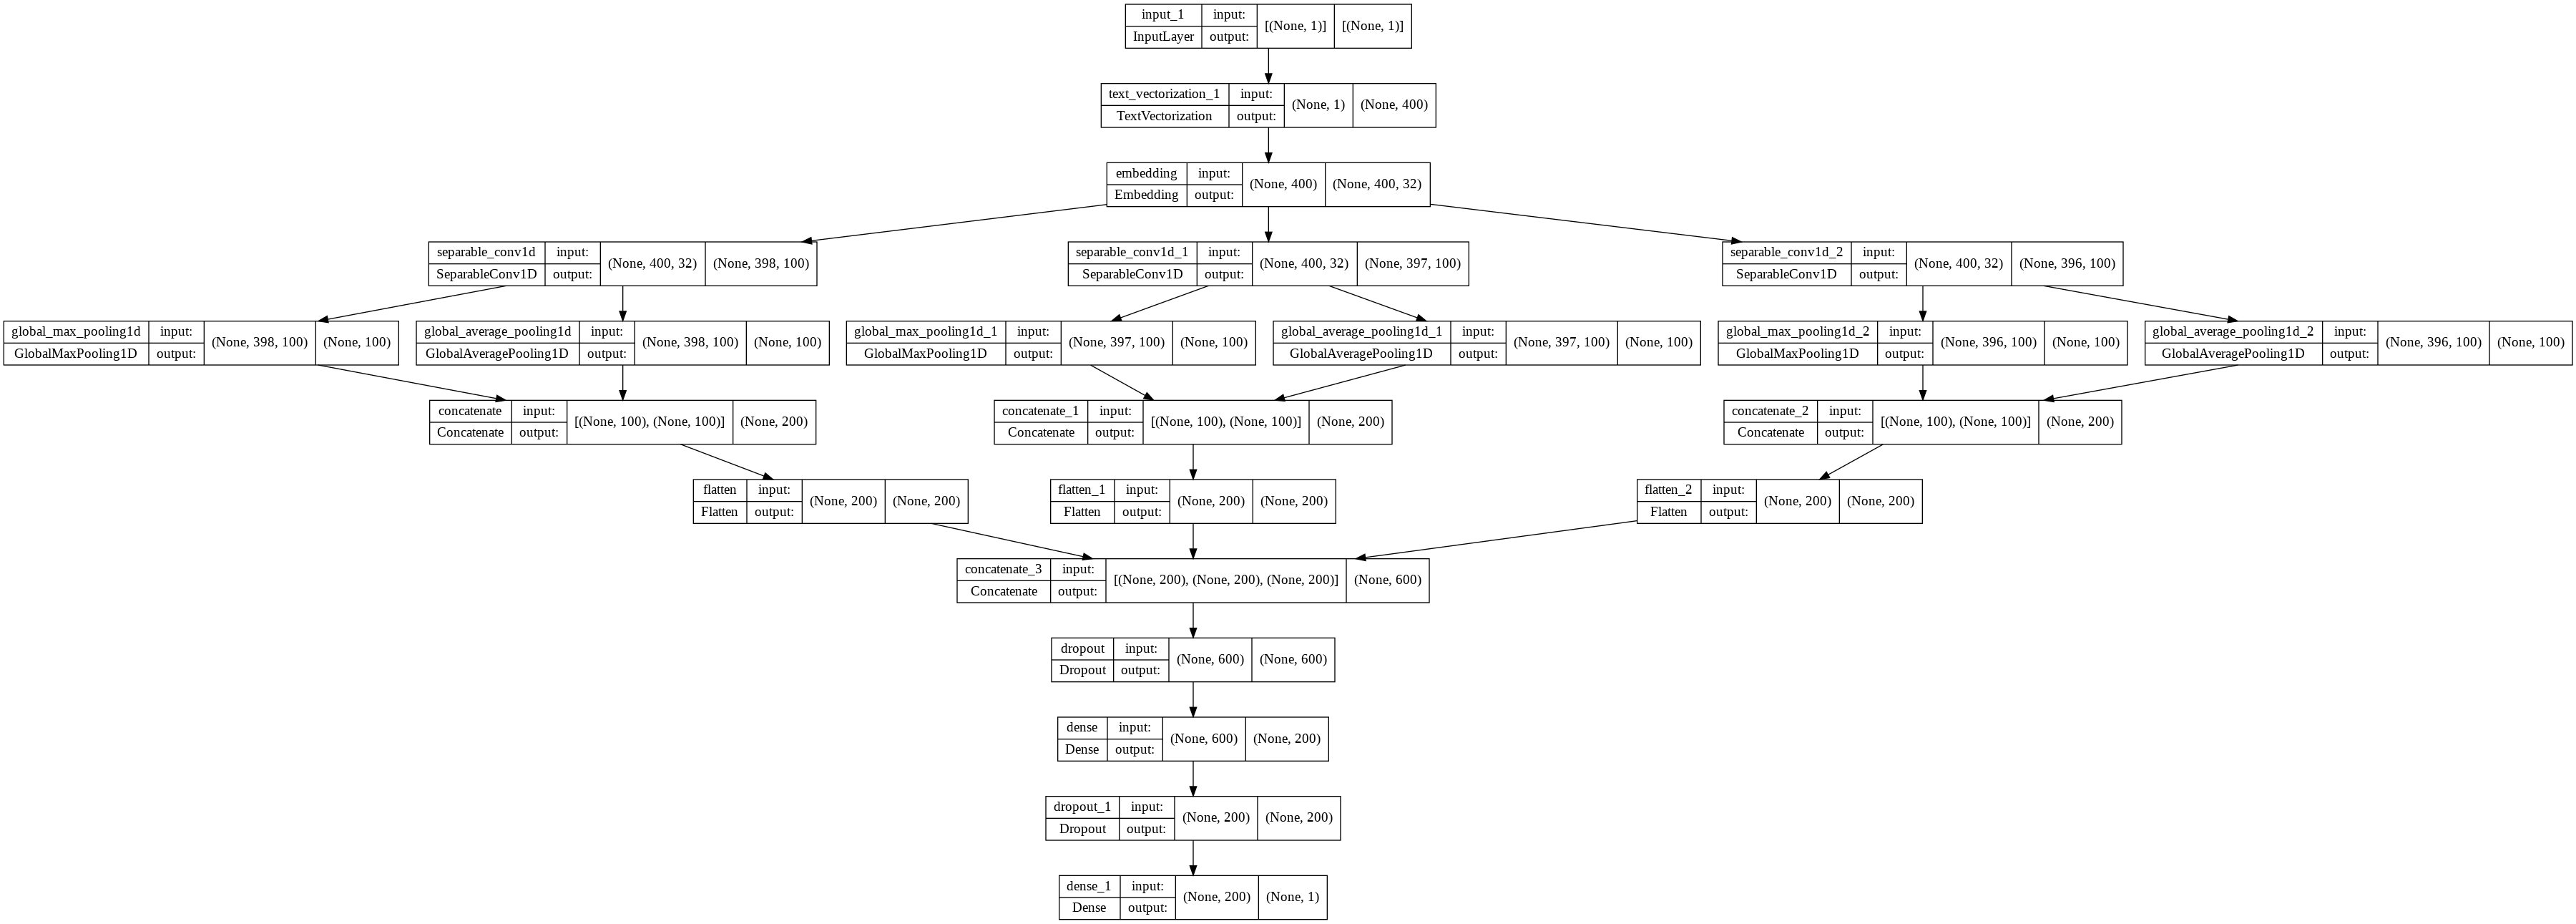

In [26]:
plot_model(model, show_shapes=True)

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 26s 30ms/step - loss: 2.3035 - accuracy: 0.5060 - val_loss: 1.3983 - val_accuracy: 0.4922
Epoch 2/10
391/391 [==============================] - 12s 28ms/step - loss: 1.0407 - accuracy: 0.5110 - val_loss: 0.8209 - val_accuracy: 0.4917
Epoch 3/10
391/391 [==============================] - 12s 28ms/step - loss: 0.7479 - accuracy: 0.5456 - val_loss: 0.7053 - val_accuracy: 0.6016
Epoch 4/10
391/391 [==============================] - 11s 28ms/step - loss: 0.6446 - accuracy: 0.6900 - val_loss: 0.5844 - val_accuracy: 0.7323
Epoch 5/10
391/391 [==============================] - 11s 28ms/step - loss: 0.5425 - accuracy: 0.7556 - val_loss: 0.5015 - val_accuracy: 0.7771
Epoch 6/10
391/391 [==============================] - 12s 28ms/step - loss: 0.4691 - accuracy: 0.7962 - val_loss: 0.4470 - val_accuracy: 0.8141
Epoch 7/10
391/391 [==============================] - 12s 28ms/step - loss: 0.4156 - accuracy: 0.8327 - val_loss: 0.4140 - val_accuracy:

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 5s 13ms/step - loss: 0.3561 - accuracy: 0.8599
Test Loss: 0.35606440901756287
Test Accuracy: 0.8599200248718262


In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

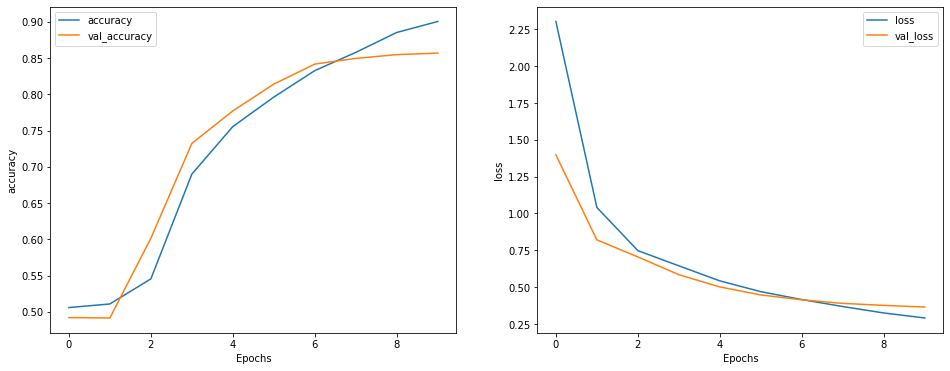

In [30]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')